In [139]:
# Importe les librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn import decomposition

<img src='./images/logo-la-poule-qui-chante.png' width=480px />

# Produisez une étude de marché avec Python<br>Partie n°2 : *clustering*

> &#9888; Ce *notebook* est le second des deux *notebooks* qui composent notre étude de marché. Il contient l'analyse des groupements de pays en utilisant la classification ascendante hiérarchique puis la méthode des *k-means*. Il contient également une ACP afin de visualier les résultats de l'analyse.

Nous sommes en poste chez **La poule qui chante**, une entreprise française d’agroalimentaire qui souhaite se développer à l'international. Cependant, la liste des pays potentiels dans lesquels s'implanter est longue. Pour cela, nous allons réaliser une analyse des groupements de pays que l'on pourra cibler grâce à différentes méthodes de *clustering*, puis nous approfondirons l'étude de marché.

Le jeu de données qui va être utilisé a été préparé à partir des [statistiques de la *Food and Agriculture Organization of the United Nations (FAO)*](https://www.fao.org/faostat/fr/#home).
Il contient différents indicateurs sélectionnés ou calculés en nous inspirant de l'analyse PESTEL dont voici la liste.
|Nom de variable             |Indicateur<sup>[1]</sup>                                        |Information                                      |
|----------------------------|-----------------------------------------------------|-------------------------------------------------|
|`population_milliers_hab`   |Population en milliers d'habitants                   |Taille du marché potentiel                       |
|`evolution_population_%`    |Evolution démographique moyenne entre 2000 et 2017   |Dynamique de la taille marché                    |
|`consommation_volaille_%`  |Ratio de consommation de volaille dans l'alimentation|Intérêt des consommateurs pour la volaille       |
|`tdi_%`                     |Taux de dépendance aux importations pour la volaille |Nécessité des pays à importer                    |
|`taux_croissance_%`         |Taux de croissance du PIB en 2017                    |Dynamique économique du pays                     |
|`revenu_par_habitant_usd`   |Revenu par habitant en US$                           |Pouvoir d'achat des consommateurs                |
|`indice_stabilite_politique`|Indice de stabilité politique                        |Facilité et risques liés aux échanges commerciaux|

*1. Les indicateurs sont donnés pour l'année 2017.*

## Sommaire

* [Importation et préparation des données](#1)
* [*Clusterings*](#2)
    * [Classification Ascendante Hiérarchique (CAH)](#2-1)
    * [K-means](#2-2)
    * [DBSCAN](#2-3)
* [ACP](#3)

## Importation et préparation des données<a id='1'></a>

Nous commençons par importer dans un *DataFrame* les indicateurs des différents pays à partir du jeu de données créé précédemment.

In [3]:
df_indicateurs = pd.read_csv('./datasets/indicateurs-pays-2017.csv')
df_indicateurs.head()

,pays,population_milliers_hab,evolution_population_%,consommation_volaille_%,tdi_%,disponibilite_kg_p_an,taux_croissance_%,revenu_par_habitant_usd,indice_stabilite_politique
0,Afghanistan,36296.113,3.29,0.42,50.88,1.53,4.865790,537.126294,-2.80
1,Afrique du Sud,57009.756,1.40,6.41,24.27,35.69,17.703800,6537.504869,-0.28
2,Albanie,2884.169,-0.45,1.29,74.51,16.36,9.765944,4532.791976,0.38
3,Algérie,41389.189,1.72,0.80,0.72,6.38,6.287893,4081.775086,-0.92
4,Allemagne,82658.409,0.12,2.06,49.24,19.47,6.441277,45734.557505,0.59


Les algorithmes de *clustering* que nous allons utiliser dans la suite de cette étude nécessitent que nous leur fournissions les données d'entrée sous forme d'un *array* NumPy ne contenant que les valeurs numériques des indicateurs. Donc allons donc créer cet *array*.

In [14]:
# Crée un array NumPy des données numériques du DataFrame
X = df_indicateurs.drop('pays', axis='columns').to_numpy()

print(X[:3])

[[ 3.62961130e+04  3.29000000e+00  4.20000000e-01  5.08800000e+01
   1.53000000e+00  4.86579000e+00  5.37126294e+02 -2.80000000e+00]
 [ 5.70097560e+04  1.40000000e+00  6.41000000e+00  2.42700000e+01
   3.56900000e+01  1.77038000e+01  6.53750487e+03 -2.80000000e-01]
 [ 2.88416900e+03 -4.50000000e-01  1.29000000e+00  7.45100000e+01
   1.63600000e+01  9.76594400e+00  4.53279198e+03  3.80000000e-01]]


Les données ayant des échelles différentes, nous allons également les centrer puis les réduire afin d'homogénéiser les variances.

In [15]:
# Instancie 'StandardScaler'
scaler = StandardScaler()

#  Calcule les moyennes et les écarts-types et standardise les données
X_scaled = scaler.fit_transform(X)

print(X_scaled[:3])

[[-0.04443898  1.56843662 -1.02862853  0.19784825 -1.19062167 -0.4422584
  -0.72800389 -3.05950463]
 [ 0.09051559  0.02232787  1.3752188  -0.36670685  0.9675434   1.50832969
  -0.39684311 -0.23729244]
 [-0.26212616 -1.491059   -0.67948877  0.69917998 -0.25368994  0.30226369
  -0.50748318  0.50185837]]


Enfin, nous stockons dans les noms de pays et noms des indicateurs.

In [16]:
# Crée la liste des pays
pays = df_indicateurs['pays'].to_numpy()

# Crée la liste des indicateurs
indicateurs = df_indicateurs.drop(columns='pays').columns.to_numpy()

## *Clusterings*<a id='2'></a>

### Classification Ascendante Hiérarchique (CAH)<a id='2-1'></a>

La première méthode que nous allons utiliser est celle de la **classification ascendante hiérarchique** qui consiste à regrouper, de manière itérative, les individus (ici nos pays), à partir de la « distance » qui les sépare. Les distances entre individus sont regroupées dans une matrice calculée à partir de nos données.

Nous allons donc calculer cette matrice des distances, aussi appelée matrice de liaison, puis nous tracerons le résultat des différentes itérations sous forme du d'un dendrogramme.

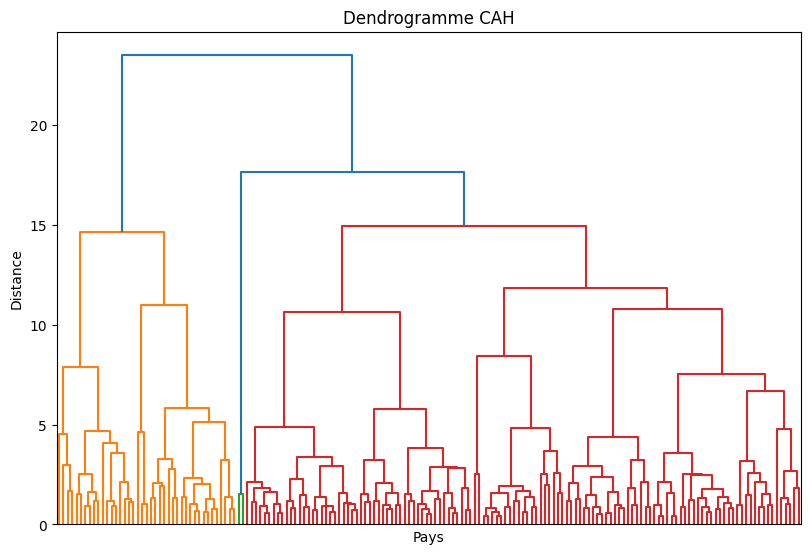

In [68]:
# Calcule la matrice de liaison
Z = linkage(X_scaled, method='ward', metric='euclidean')

# Initialise le graphique
fig, ax = plt.subplots(figsize=(9.6, 6.4))

# Trace le dendogramme
dn = dendrogram(Z, no_labels=True, orientation='top', ax=ax)

ax.set_title('Dendrogramme CAH')
ax.set_xlabel('Pays')
ax.set_ylabel('Distance')

plt.show()

del  fig, ax, dn

Nous devons maintenant découper le dendrogramme à certaine distance pour former nos groupes de pays. Cependant, avec le nombre d'individus que nous avons, le choix du nombre de *clusters* par lecture du graphique n'est pas aisé. Pour nous aider dasn cette tâche, nous allons représenter les sauts d’inertie du dendrogramme selon le nombre de groupes retenus.

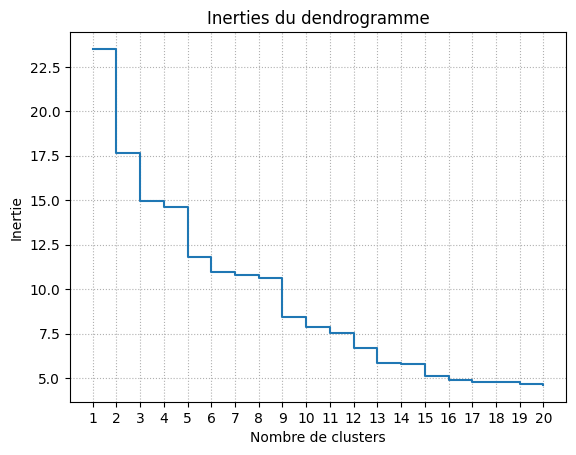

In [112]:
# Récupère les inerties
inertias = Z[:, 2]

# Tri les inerties par ordre décroissant
inertias = np.flip(np.sort(inertias))

# Crée la liste des clusters pour l'axe x
n_clusters = range(1, (len(inertias)+1))

# Initialise le graphique
fig, ax = plt.subplots(figsize=(6.4, 4.8))

# Trace le graphique
plt.step(n_clusters[:20], inertias[:20],  where='post')

# Définie la position des graduations et affiche le quadrillage
ax.xaxis.set_major_locator(ticker.IndexLocator(1, 0))
ax.grid(axis='both', which='major', visible=True, linestyle=':')

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Inertie')
ax.set_title('Inerties du dendrogramme')

plt.show()

On observe plusieurs sauts importants à 2, 3, 5 et 9 *clusters*. Etant donné le nombre de pays que nous devons analyser, nous retenons 9 groupes.

In [146]:
# Initialise le nombre de clusters
n_clusters = 9

# Effectue le clustering
clustering = fcluster(Z, t=n_clusters, criterion='maxclust')

On ajoute au *DataFrame* d'origine le *cluster* auquel chaque pays appartient.

In [147]:
# Crée la colonne des clusters de la CAH
df_indicateurs['cluster_cah'] = clustering

Voyons de quels pays sont composés chacun des *clusters*.

In [148]:
for i in range(1, (n_clusters+1)):
    print(f'Cluster {i} - {len(df_indicateurs.loc[df_indicateurs["cluster_cah"] == i, "pays"].to_list())} pays')
    print(df_indicateurs.loc[df_indicateurs["cluster_cah"] == i, 'pays'].to_list())

Cluster 1 - 18 pays
['Antigua-et-Barbuda', 'Arabie saoudite', 'Bahamas', 'Barbade', 'Dominique', 'Émirats arabes unis', 'Grenade', 'Israël', 'Jamaïque', 'Koweït', 'Maurice', 'Nouvelle-Calédonie', 'Polynésie française', 'Sainte-Lucie', 'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines', 'Samoa', 'Trinité-et-Tobago']
Cluster 2 - 3 pays
['Belgique', 'Chine - RAS de Hong-Kong', 'Pays-Bas']
Cluster 3 - 20 pays
['Allemagne', 'Australie', 'Autriche', 'Canada', 'Chine - RAS de Macao', 'Danemark', "États-Unis d'Amérique", 'Finlande', 'France', 'Irlande', 'Islande', 'Italie', 'Japon', 'Luxembourg', 'Norvège', 'Nouvelle-Zélande', 'République de Corée', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Suède', 'Suisse']
Cluster 4 - 2 pays
['Chine, continentale', 'Inde']
Cluster 5 - 26 pays
['Albanie', 'Arménie', 'Bosnie-Herzégovine', 'Bulgarie', 'Chypre', 'Croatie', 'Cuba', 'Espagne', 'Estonie', 'Fidji', 'Géorgie', 'Grèce', 'Hongrie', 'Lesotho', 'Lettonie', 'Lituanie', 'Macédoine du N

Nous allons également calculer les valeurs moyennes de chaque indicateur pour chaque groupe de pays.

In [149]:
# Calcule la moyenne des indicateurs de chaque clusters
cah_clusters_statistics = (
    df_indicateurs.groupby('cluster_cah')[indicateurs].mean()
)

# Affiche le résultat sous forme de tableau
cah_clusters_statistics.style.background_gradient(axis='rows').format('{:.2f}')

,population_milliers_hab,evolution_population_%,consommation_volaille_%,tdi_%,disponibilite_kg_p_an,taux_croissance_%,revenu_par_habitant_usd,indice_stabilite_politique
cluster_cah,,,,,,,,
1,3471.94,1.40,8.28,69.09,50.26,4.82,19205.72,0.54
2,11915.81,0.54,3.43,260.40,28.83,6.16,46731.76,0.73
3,44731.37,0.85,2.98,35.67,26.57,6.64,53939.68,0.92
4,1379849.29,0.97,0.84,1.25,7.28,12.08,5317.33,-0.49
5,7494.07,-0.08,2.37,47.74,20.25,9.03,13089.46,0.43
6,39256.92,1.43,4.53,8.75,29.11,6.24,7352.74,-0.35
7,49992.74,2.73,1.03,15.78,5.01,3.72,1869.13,-1.53
8,4392.69,2.50,2.05,85.10,11.87,5.54,3414.44,0.09
9,36002.17,1.33,1.31,24.16,8.84,13.93,3511.62,-0.37


Enfin, on 

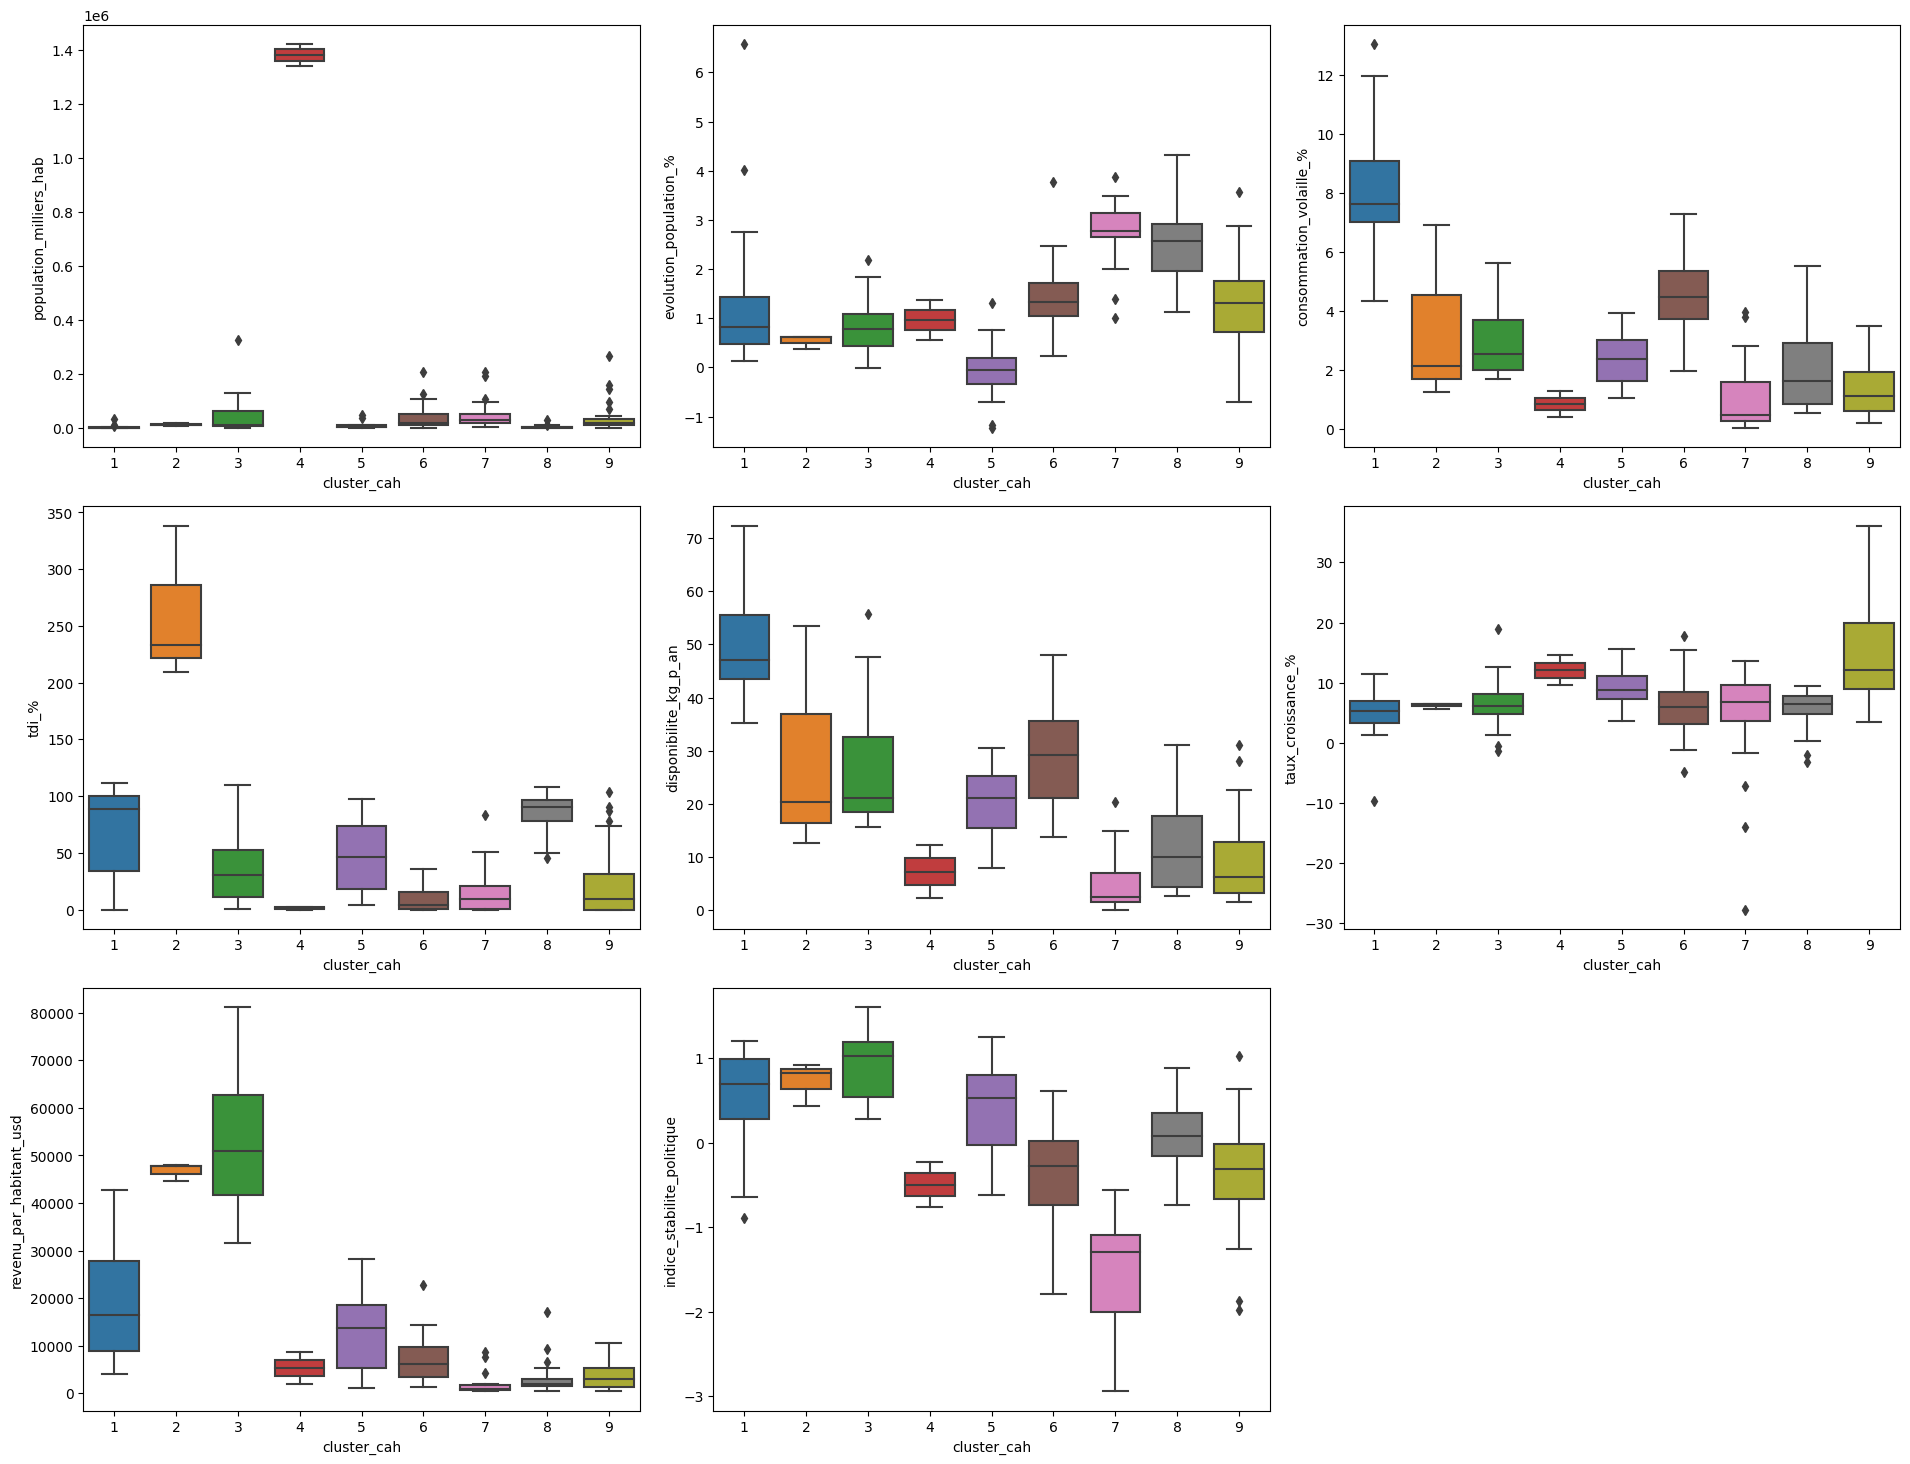

In [150]:
fig, axs = plt.subplots(len(indicateurs), 3, figsize=(6.4*3, 4.8*len(indicateurs)))

for i, indicateur in enumerate(indicateurs):
    r = i // 3
    c = i % 3
    sns.boxplot(y=df_indicateurs[indicateur], x=df_indicateurs['cluster_cah'], ax=axs[r, c])

# Supprime les graphiques vides
[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]

fig.tight_layout()

plt.show()

<Axes: xlabel='tdi_%', ylabel='consommation_volaille_%'>

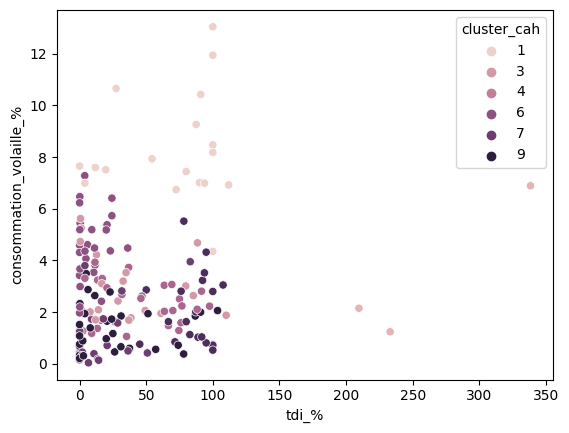

In [171]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))

sns.scatterplot(data=df_indicateurs, x='tdi_%', y='consommation_volaille_%', hue='cluster_cah')

### K-Means<a id='2-2'></a>

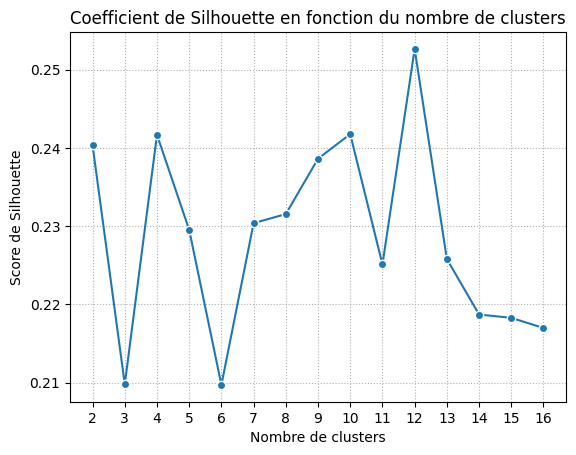

In [172]:
#Initialise les variables
silhouette_avg_scores = []
max_n_clusters = 16

# Calcul le score de Silhouette moyen chaque nombre de clusters et
# l'ajoute à la liste.
for n_clusters in range(2, (max_n_clusters+1)):
    clustering = KMeans(n_clusters=n_clusters, n_init='auto', init='random',
                        random_state=0).fit(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, clustering.labels_)
    silhouette_avg_scores.append(silhouette_avg)

# Initialise le graphique
fig, ax = plt.subplots(figsize=(6.4, 4.8))

# Trace le graphique
plt.plot(range(2, (max_n_clusters+1)), silhouette_avg_scores, marker='o',
            markeredgecolor='w')

# Définie la position des graduations et affiche le quadrillage
ax.xaxis.set_major_locator(ticker.IndexLocator(1, 0))
ax.grid(axis='both', which='major', visible=True, linestyle=':')

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score de Silhouette')
ax.set_title('Coefficient de Silhouette en fonction du nombre de clusters')

plt.show()

del (silhouette_avg_scores, max_n_clusters, n_clusters, clustering,
     silhouette_avg)

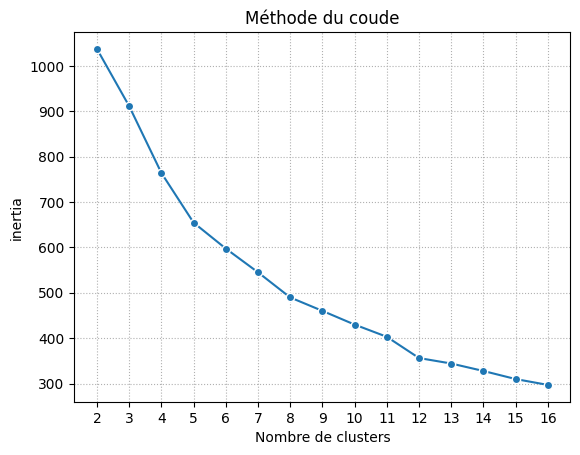

In [173]:
#Initialise les variables
inertias=[]
max_n_clusters = 16


for n_clusters in range(2, (max_n_clusters+1)):
    clustering = KMeans(n_clusters=n_clusters, n_init='auto', init='random',
                      random_state=0).fit(X_scaled)
    inertias.append(clustering.inertia_)

# Initialise le graphique
fig, ax = plt.subplots(figsize=(6.4, 4.8))

# Trace le graphique
plt.plot(range(2, (max_n_clusters+1)), inertias, marker='o',
         markeredgecolor='w')

# Définie la position des graduations et affiche le quadrillage
ax.xaxis.set_major_locator(ticker.IndexLocator(1, 0))
ax.grid(axis='both', which='major', visible=True, linestyle=':')

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('inertia')
ax.set_title('Méthode du coude')

plt.show()

del inertias, max_n_clusters, n_clusters, clustering

In [177]:
# Effectue le clustering
n_clusters = 12
clustering = KMeans(n_clusters=n_clusters, n_init='auto', init='random',
                    random_state=0)
clustering.fit(X_scaled)

KMeans(init='random', n_clusters=12, n_init='auto', random_state=0)

In [178]:
# Ajoute au jeu de donnée initiale une colonne avec le cluster
df_indicateurs['cluster_kmeans'] = clustering.labels_ + 1

# Affiche les clusters et les pays qui les composent
for i in range(1, (n_clusters+1)):
    print(f'Cluster {i} - {len(df_indicateurs.loc[df_indicateurs["cluster_kmeans"] == i, "pays"].to_list())} pays')
    print(df_indicateurs.loc[df_indicateurs["cluster_kmeans"] == i, 'pays'].to_list())

Cluster 1 - 27 pays
['Afrique du Sud', 'Argentine', 'Belize', 'Bolivie (État plurinational de)', 'Brésil', 'Chili', 'Chine, Taiwan Province de', 'Chypre', 'Colombie', 'Costa Rica', 'El Salvador', 'Équateur', 'Espagne', 'Fidji', 'Guatemala', 'Guyana', 'Honduras', "Iran (République islamique d')", 'Malaisie', 'Maroc', 'Maurice', 'Mexique', 'Myanmar', 'Nicaragua', 'Panama', 'République dominicaine', 'Suriname']
Cluster 2 - 5 pays
['Égypte', 'Nigéria', 'Tunisie', 'Turquie', 'Venezuela (République bolivarienne du)']
Cluster 3 - 18 pays
['Bénin', 'Botswana', 'Cabo Verde', 'Congo', 'Djibouti', 'Gambie', 'Ghana', 'Îles Salomon', 'Kiribati', 'Libéria', 'Maldives', 'Mauritanie', 'Mongolie', 'Sao Tomé-et-Principe', 'Sierra Leone', 'Tadjikistan', 'Timor-Leste', 'Vanuatu']
Cluster 4 - 6 pays
['Arabie saoudite', 'Émirats arabes unis', 'Gabon', 'Jordanie', 'Koweït', 'Oman']
Cluster 5 - 18 pays
['Allemagne', 'Australie', 'Autriche', 'Canada', 'Chine - RAS de Macao', 'Danemark', "États-Unis d'Amérique"

In [179]:
# Calcule la moyenne des indicateurs de chaque clusters
kmeans_clusters_statistics = (
    df_indicateurs.groupby('cluster_kmeans')[indicateurs].mean()
)

# Affiche le résultat sous forme de tableau
kmeans_clusters_statistics.style.background_gradient(axis='rows').format('{:.2f}')

,population_milliers_hab,evolution_population_%,consommation_volaille_%,tdi_%,disponibilite_kg_p_an,taux_croissance_%,revenu_par_habitant_usd,indice_stabilite_politique
cluster_kmeans,,,,,,,,
1,31989.29,1.23,4.77,12.26,30.73,7.51,8819.31,-0.08
2,81853.64,1.62,1.97,2.63,14.38,-11.04,5016.73,-1.50
3,4597.65,2.40,1.59,81.04,8.82,5.31,2516.37,0.11
4,10526.85,4.08,5.78,77.61,35.35,7.16,20802.87,0.02
5,43492.07,0.90,3.08,38.41,27.55,6.67,56347.97,0.99
6,58722.72,0.01,2.31,10.54,17.84,24.82,4756.17,-1.20
7,52520.01,2.42,0.93,14.01,4.64,6.92,1834.80,-1.28
8,1041.85,0.82,8.61,71.49,52.40,3.77,16993.43,0.64
9,1379849.29,0.97,0.84,1.25,7.28,12.08,5317.33,-0.49


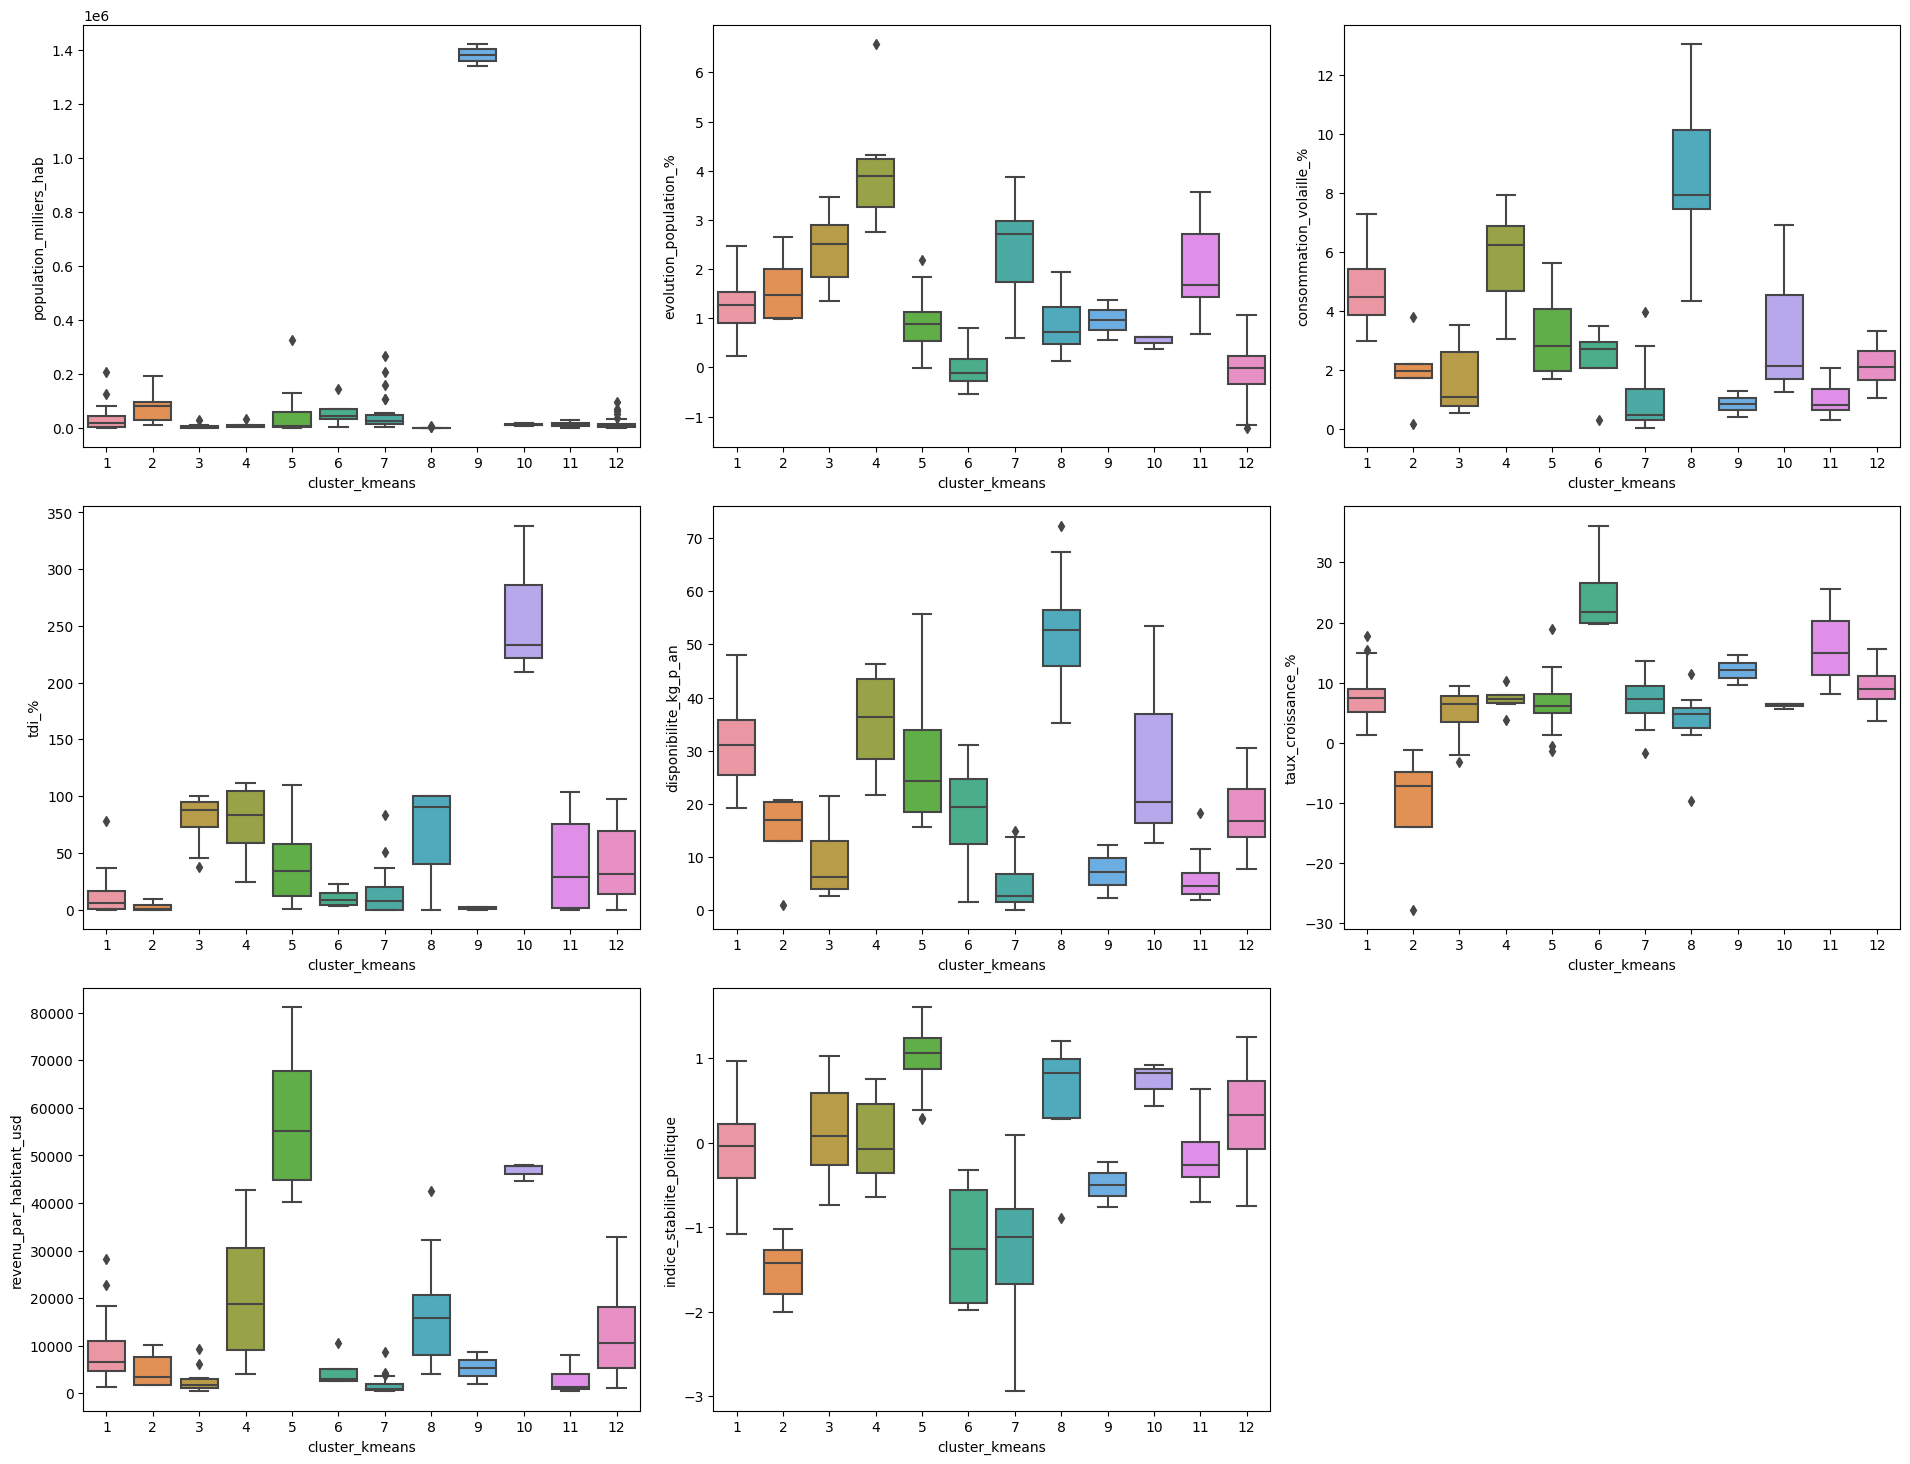

In [180]:
fig, axs = plt.subplots(len(indicateurs), 3, figsize=(6.4*3, 4.8*len(indicateurs)))

for i, indicateur in enumerate(indicateurs):
    r = i // 3
    c = i % 3
    sns.boxplot(y=df_indicateurs[indicateur], x=df_indicateurs['cluster_kmeans'], ax=axs[r, c])

# Supprime les graphiques vides
[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]

fig.tight_layout()

plt.show()

<Axes: xlabel='tdi_%', ylabel='consommation_volaille_%'>

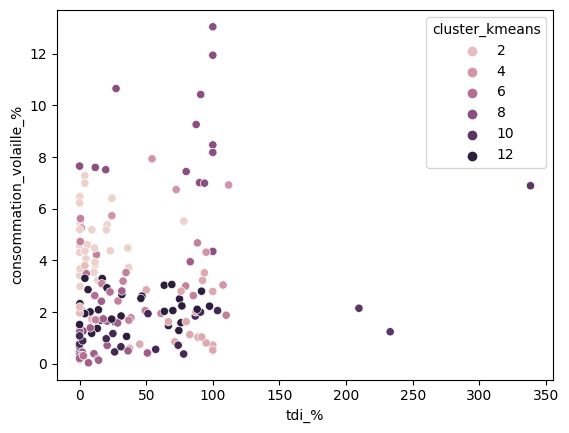

In [181]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))

sns.scatterplot(data=df_indicateurs, x='tdi_%', y='consommation_volaille_%', hue='cluster_kmeans')

### DBSCAN<a id='2-3'></a>

In [215]:
# Effectue le clustering
clustering = DBSCAN(eps=0.99, min_samples=2)
clustering.fit(X_scaled)

n_clusters_ = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
n_noise_ = list(clustering.labels_).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 11
Estimated number of noise points: 77


In [213]:
clustering.labels_

array([-1, -1,  0,  1,  2, -1, -1, -1,  3,  0, -1,  2,  1,  4, -1, -1,  0,
       -1, -1,  5, -1,  1, -1, -1,  0,  1, -1,  1,  1,  6,  3, -1, -1, -1,
       -1, -1,  1,  7,  3,  1,  1, -1, -1,  5, -1, -1,  1, -1,  1, -1,  0,
        1, -1,  1, -1,  0,  2,  2,  7,  5,  0,  5, -1,  8,  1,  9,  9,  3,
       10,  1,  0,  5, -1, -1,  1, -1, -1, -1, -1,  2, -1, -1, -1, -1,  1,
       10, -1, -1,  0,  0, -1, -1,  0, -1,  0,  1, -1, -1,  5,  1, -1,  1,
       -1,  5,  1, -1,  0,  1, -1, -1,  1,  1,  1, -1, -1,  4,  6, -1,  1,
       -1,  3,  1, -1,  1, -1,  0, -1,  0, -1,  2, -1,  3,  1,  1, -1, -1,
        1,  8, -1, -1, -1,  5,  1,  1, -1,  1,  0, -1,  1,  2, -1, -1,  5,
        1,  0,  1, -1,  1, -1, -1,  1, -1, -1, -1,  5, -1,  1, -1, -1,  1],
      dtype=int64)

In [217]:
# Ajoute au jeu de donnée initiale une colonne avec le cluster
df_indicateurs['cluster_dbscan'] = clustering.labels_

# Affiche les clusters et les pays qui les composent
for i in range(-1, (n_clusters-1)):
    print(f'Cluster {i} - {len(df_indicateurs.loc[df_indicateurs["cluster_dbscan"] == i, "pays"].to_list())} pays')
    print(df_indicateurs.loc[df_indicateurs["cluster_dbscan"] == i, 'pays'].to_list())

Cluster -1 - 77 pays
['Afghanistan', 'Afrique du Sud', 'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Australie', 'Bangladesh', 'Barbade', 'Belgique', 'Belize', 'Bolivie (État plurinational de)', 'Botswana', 'Brésil', 'Cabo Verde', 'Chine - RAS de Hong-Kong', 'Chine - RAS de Macao', 'Chine, continentale', 'Chine, Taiwan Province de', 'Chypre', 'Cuba', 'Danemark', 'Dominique', 'Égypte', 'Émirats arabes unis', 'Espagne', "États-Unis d'Amérique", 'Fédération de Russie', 'Grèce', 'Inde', 'Indonésie', 'Iraq', 'Irlande', 'Islande', 'Israël', 'Jamaïque', 'Japon', 'Jordanie', 'Kazakhstan', 'Kiribati', 'Koweït', 'Liban', 'Libéria', 'Luxembourg', 'Malaisie', 'Malawi', 'Malte', 'Maurice', 'Mongolie', 'Myanmar', 'Namibie', 'Nigéria', 'Norvège', 'Oman', 'Pakistan', 'Pays-Bas', 'Philippines', 'Polynésie française', 'République centrafricaine', 'République de Moldova', 'Roumanie', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines', 'S

In [218]:
# Calcule la moyenne des indicateurs de chaque clusters
dbscan_clusters_statistics = (
    df_indicateurs.groupby('cluster_dbscan')[indicateurs].mean()
)

# Affiche le résultat sous forme de tableau
dbscan_clusters_statistics.style.background_gradient(axis='rows').format('{:.2f}')

,population_milliers_hab,evolution_population_%,consommation_volaille_%,tdi_%,disponibilite_kg_p_an,taux_croissance_%,revenu_par_habitant_usd,indice_stabilite_politique
cluster_dbscan,,,,,,,,
-1,71668.03,1.45,3.76,48.71,25.27,7.19,18535.41,-0.07
0,6404.34,-0.23,2.51,51.32,21.90,9.83,11031.88,0.35
1,29205.52,1.70,1.56,11.08,9.71,7.92,3548.35,-0.52
2,40501.03,0.43,2.00,30.25,18.79,5.85,42825.77,0.67
3,13792.10,1.12,4.77,8.83,35.42,7.99,11336.47,0.29
4,329.45,1.43,7.22,85.00,40.94,4.82,31164.63,0.64
5,5824.25,2.59,1.33,87.21,7.65,7.07,2532.18,-0.07
6,20717.06,1.11,4.47,6.58,36.91,8.68,43224.69,1.35
7,3587.76,3.00,3.92,94.34,25.43,7.51,4164.96,-0.32


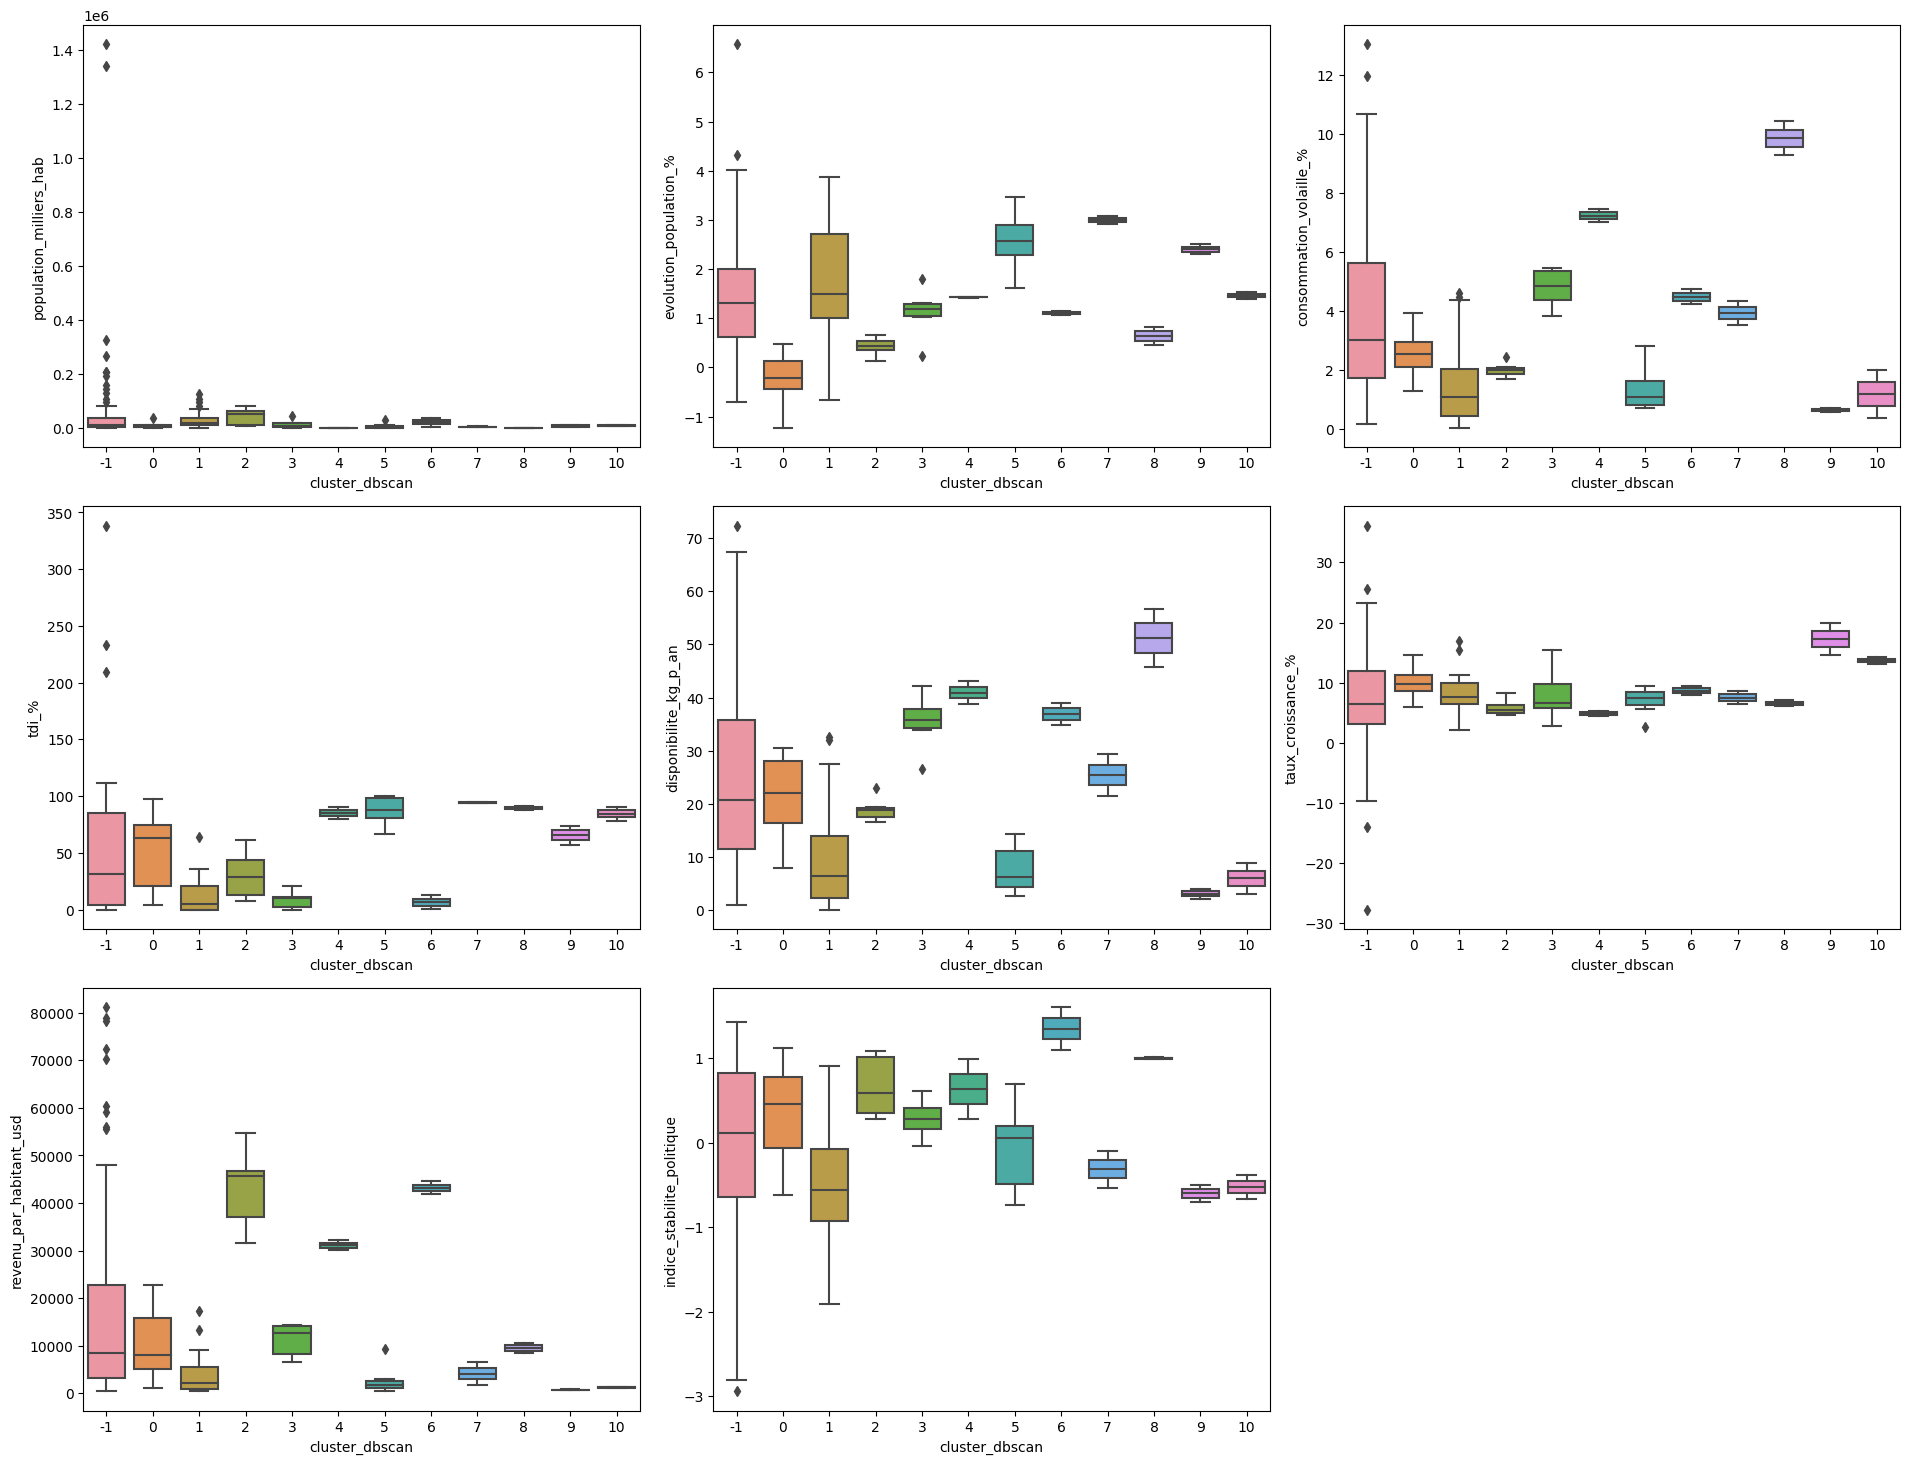

In [219]:
fig, axs = plt.subplots(len(indicateurs), 3, figsize=(6.4*3, 4.8*len(indicateurs)))

for i, indicateur in enumerate(indicateurs):
    r = i // 3
    c = i % 3
    sns.boxplot(y=df_indicateurs[indicateur], x=df_indicateurs['cluster_dbscan'], ax=axs[r, c])

# Supprime les graphiques vides
[fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]

fig.tight_layout()

plt.show()

## ACP<a id='3'></a>

In [220]:
pca = decomposition.PCA(n_components=7)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_.cumsum())

[0.34346024 0.49405826 0.63983251 0.75511388 0.8608161  0.94719288
 0.99433255]


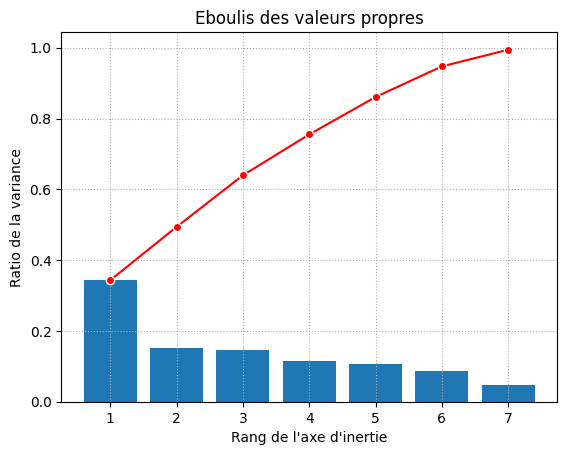

In [221]:
fig, ax = plt.subplots()

plt.bar(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_)
plt.plot(np.arange(len(pca.explained_variance_ratio_.cumsum()))+1, pca.explained_variance_ratio_.cumsum(), c='r',marker='o',  markeredgecolor='w')

ax.grid(axis='both', which='major', visible=True, linestyle=':')

ax.set_xlabel('Rang de l\'axe d\'inertie')
ax.set_ylabel('Ratio de la variance')
ax.set_title('Eboulis des valeurs propres')

plt.show()

In [222]:
pca = decomposition.PCA(n_components=5)
pca.fit(X_scaled)

X_projected = pca.transform(X_scaled)

In [128]:
df_indicateurs.columns

Index(['population_milliers_hab', 'evolution_population_%',
       'consommation_volailles_%', 'tdi_%', 'disponibilite_kg_p_an',
       'croissance_annuelle_%', 'revenu_par_habitant_usd',
       'indice_stabilite_politique'],
      dtype='object')

In [246]:
# Créer le cercle de corrélation
coeff = np.transpose(pca.components_[0:2, :])
# coeff = np.transpose(pca.components_)
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

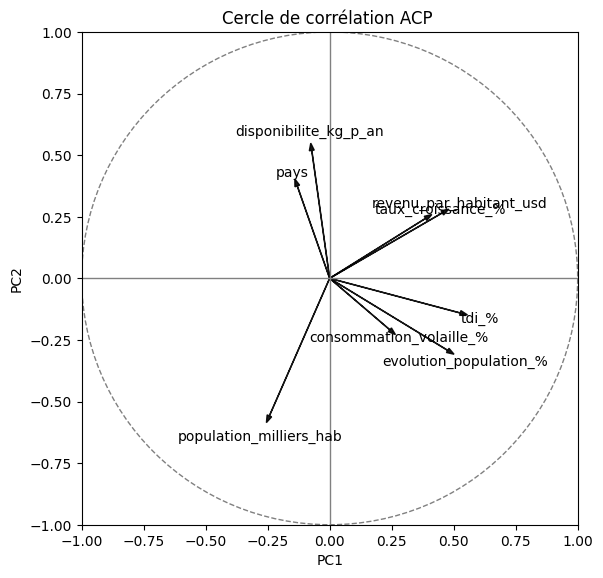

In [247]:
# Créer la figure
plt.figure(figsize=(6.4, 6.4))

# Placer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, df_indicateurs.columns[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cercle de corrélation ACP ')

# Afficher la figure
plt.show()

In [248]:
# Créer le cercle de corrélation
coeff = np.transpose(pca.components_[2:5, :])
# coeff = np.transpose(pca.components_)
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

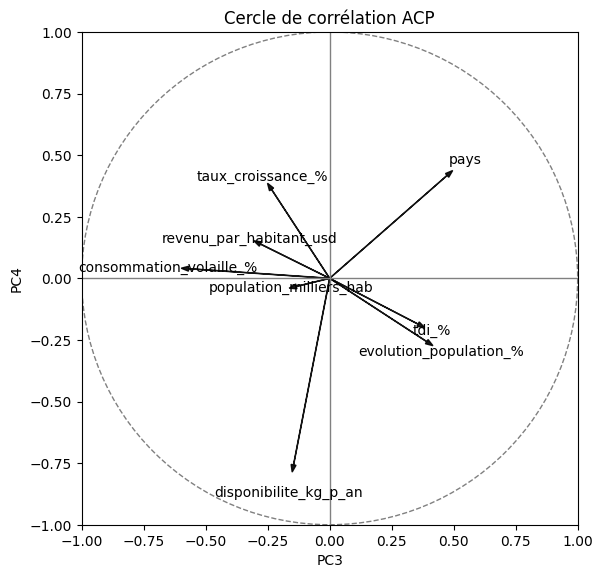

In [249]:
# Créer la figure
plt.figure(figsize=(6.4, 6.4))

# Placer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, df_indicateurs.columns[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel('PC3')
plt.ylabel('PC4')
plt.title('Cercle de corrélation ACP')

# Afficher la figure
plt.show()

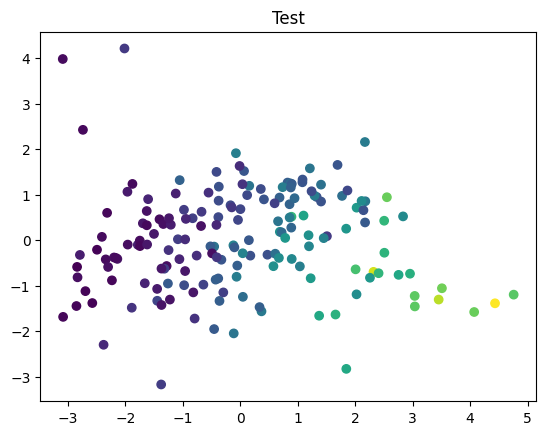

In [229]:
fig = plt.figure()
ax = fig.add_subplot()

# afficher chaque observation
ax.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable 'Rank'
    c=df_indicateurs['disponibilite_kg_p_an'])
ax.set_title('Test')
# ax.set_xlim([-4, 4])
# ax.set_ylim([-4, 4])

plt.show()

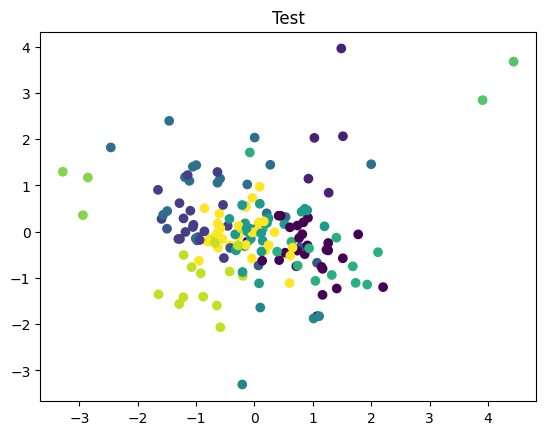

In [230]:
fig = plt.figure()
ax = fig.add_subplot()

# afficher chaque observation
ax.scatter(X_projected[:, 2], X_projected[:, 3],
    # colorer en utilisant la variable 'Rank'
    c=df_indicateurs['cluster_kmeans'])
ax.set_title('Test')
# ax.set_xlim([-4, 4])
# ax.set_ylim([-4, 4])

plt.show()

NameError: name 'cluster' is not defined

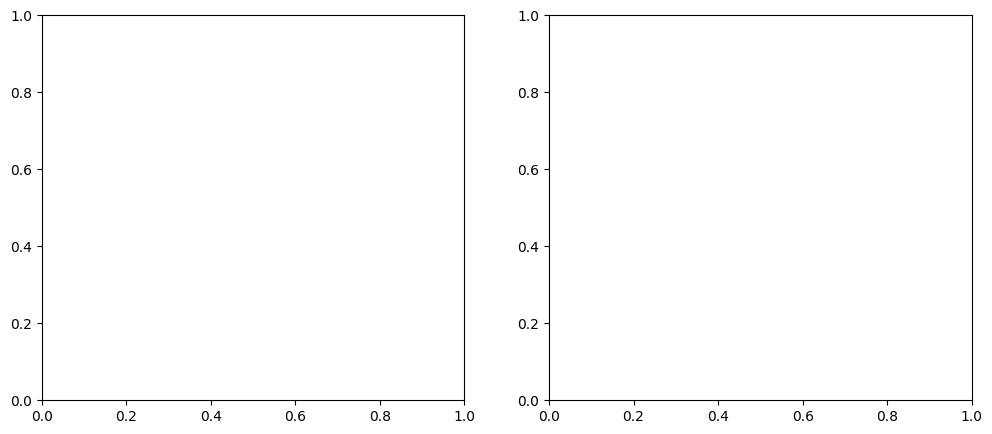

In [231]:
# Affiche les données pour 2 et 3 clusters
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cls2 = cluster.KMeans(n_clusters=2, n_init=1)
cls2.fit(X_norm)
ax[0].scatter(X_trans[:, 0], X_trans[:, 1], c=cls2.labels_)

cls3 = cluster.KMeans(n_clusters=10, n_init=1)
cls3.fit(X_norm)
ax[1].scatter(X_trans[:, 0], X_trans[:, 1], c=cls3.labels_)